Основная цель данного проекта — разработать модель машинного обучения, способную прогнозировать вероятность снижения покупательской активности постоянных клиентов интернет-магазина «В один клик» в течение следующих трёх месяцев. На основе полученных прогнозов и данных о прибыльности клиентов необходимо выделить ключевые сегменты покупателей и разработать персонализированные маркетинговые стратегии для их удержания и стимулирования повторных покупок.

Актуальность задачи
Интернет-магазин столкнулся с проблемой снижения активности своей постоянной аудитории. Привлечение новых клиентов становится всё менее эффективным, поскольку основная целевая аудитория уже знает о магазине. В этих условиях стратегия удержания существующих клиентов (customer retention) становится критически важной для роста выручки и прибыли.

In [2]:
# Репозиторий проекта: https://github.com/turboflash6789-glitch/customer-retention-ml

 ## Загрузка данных

### загрузка данных

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, roc_auc_score
!pip install shap
import shap
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
!pip install phik
import phik
from sklearn.preprocessing import OneHotEncoder
import re
!pip install -U scikit-learn


plt.style.use('default')
sns.set_palette("tab10")


market_file = pd.read_csv('/datasets/market_file.csv', sep=',', decimal='.')
market_money = pd.read_csv('/datasets/market_money.csv', sep=',', decimal='.')
market_time = pd.read_csv('/datasets/market_time.csv', sep=',', decimal='.')


print("✅ Данные успешно загружены!")

print("✅ market_file — колонок:", market_file.shape[1])
print("✅ market_money — колонок:", market_money.shape[1])
print("✅ market_time — колонок:", market_time.shape[1])

     |████████████████████████████████| 999 kB 1.7 MB/s eta 0:00:01
     |████████████████████████████████| 677 kB 1.6 MB/s eta 0:00:01
     |████████████████████████████████| 13.5 MB 1.6 MB/s eta 0:00:01
     |████████████████████████████████| 308 kB 71.0 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1
✅ Данные успешно загружены!
✅ market_file — колонок: 13
✅ market_money — колонок: 3
✅ market_time — колонок: 3


### Проверка соответствия данных описанию

In [2]:


# Функция для приведения к snake_case
def to_snake_case(name):
    name = re.sub(r'[^\w\s]', ' ', name, flags=re.UNICODE)
    name = re.sub(r'\s+', '_', name)
    name = re.sub(r'_+', '_', name)
    return name.strip('_').lower()

# === Исправление опечаток ===
market_file['Тип сервиса'] = market_file['Тип сервиса'].replace('стандартт', 'стандарт')
market_time['Период'] = market_time['Период'].replace('предыдцщий_месяц', 'предыдущий_месяц')

# === Загрузка money.csv ===
money_raw = pd.read_csv(
    '/datasets/money.csv',
    sep=';',
    skiprows=1,
    header=None,
    names=['id', 'Прибыль_raw']
)
money_raw['Прибыль'] = (
    money_raw['Прибыль_raw']
    .astype(str)
    .str.replace(r'[^\d.]', '', regex=True)
    .replace('', np.nan)
    .astype(float)
)
money_raw['id'] = pd.to_numeric(money_raw['id'], errors='coerce').astype('Int64')
money = money_raw[['id', 'Прибыль']].dropna(subset=['id']).reset_index(drop=True)

# === 🔥 Приведение названий столбцов к snake_case ===
market_file.columns = [to_snake_case(col) for col in market_file.columns]
market_money.columns = [to_snake_case(col) for col in market_money.columns]
market_time.columns = [to_snake_case(col) for col in market_time.columns]
money.columns = [to_snake_case(col) for col in money.columns]

print("✅ money — колонок:", money.shape[1])
print("✅ money — клиентов:", money.shape[0])

# === Проверка структуры ===
print("\n📊 market_file.csv")
display(market_file.head())
market_file.info()
# ... остальной вывод

✅ money — колонок: 2
✅ money — клиентов: 1300

📊 market_file.csv


,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

## Предобработка данных

###  Проверка дубликатов по id в каждой таблице

In [3]:
print("Проверка дубликатов по id:")
print("market_file: дубликатов id =", market_file['id'].duplicated().sum())
print("money:       дубликатов id =", money['id'].duplicated().sum())

Проверка дубликатов по id:
market_file: дубликатов id = 0
money:       дубликатов id = 0


### Проверка согласованности наборов клиентов

In [4]:
ids_market = set(market_file['id'].unique())
ids_money = set(money['id'].unique())

print("\n Сравнение наборов клиентов:")
print("Все id совпадают между market_file и money:", ids_market == ids_money)
print("Количество клиентов везде:", len(ids_market))


 Сравнение наборов клиентов:
Все id совпадают между market_file и money: True
Количество клиентов везде: 1300


###  Анализ целевого признака — баланс классов


 Баланс целевого признака 'покупательская_активность':


Прежний уровень    802
Снизилась          498
Name: покупательская_активность, dtype: int64

Прежний уровень    0.617
Снизилась          0.383
Name: покупательская_активность, dtype: float64

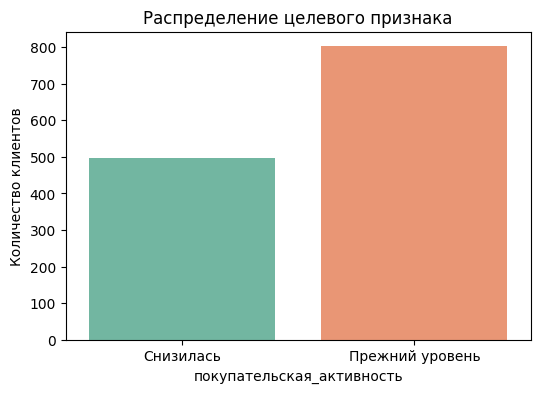

In [5]:
print("\n Баланс целевого признака 'покупательская_активность':")
display(market_file['покупательская_активность'].value_counts())
display(market_file['покупательская_активность'].value_counts(normalize=True).round(3))

# Визуализация
plt.figure(figsize=(6, 4))
sns.countplot(data=market_file, x='покупательская_активность', palette='Set2')
plt.title('Распределение целевого признака')
plt.ylabel('Количество клиентов')
plt.show()

### Анализ числовых признаков в market_file

 Дискретные признаки (4): ['маркет_актив_тек_мес', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса']
 Непрерывные признаки (4): ['маркет_актив_6_мес', 'длительность', 'акционные_покупки', 'страниц_за_визит']


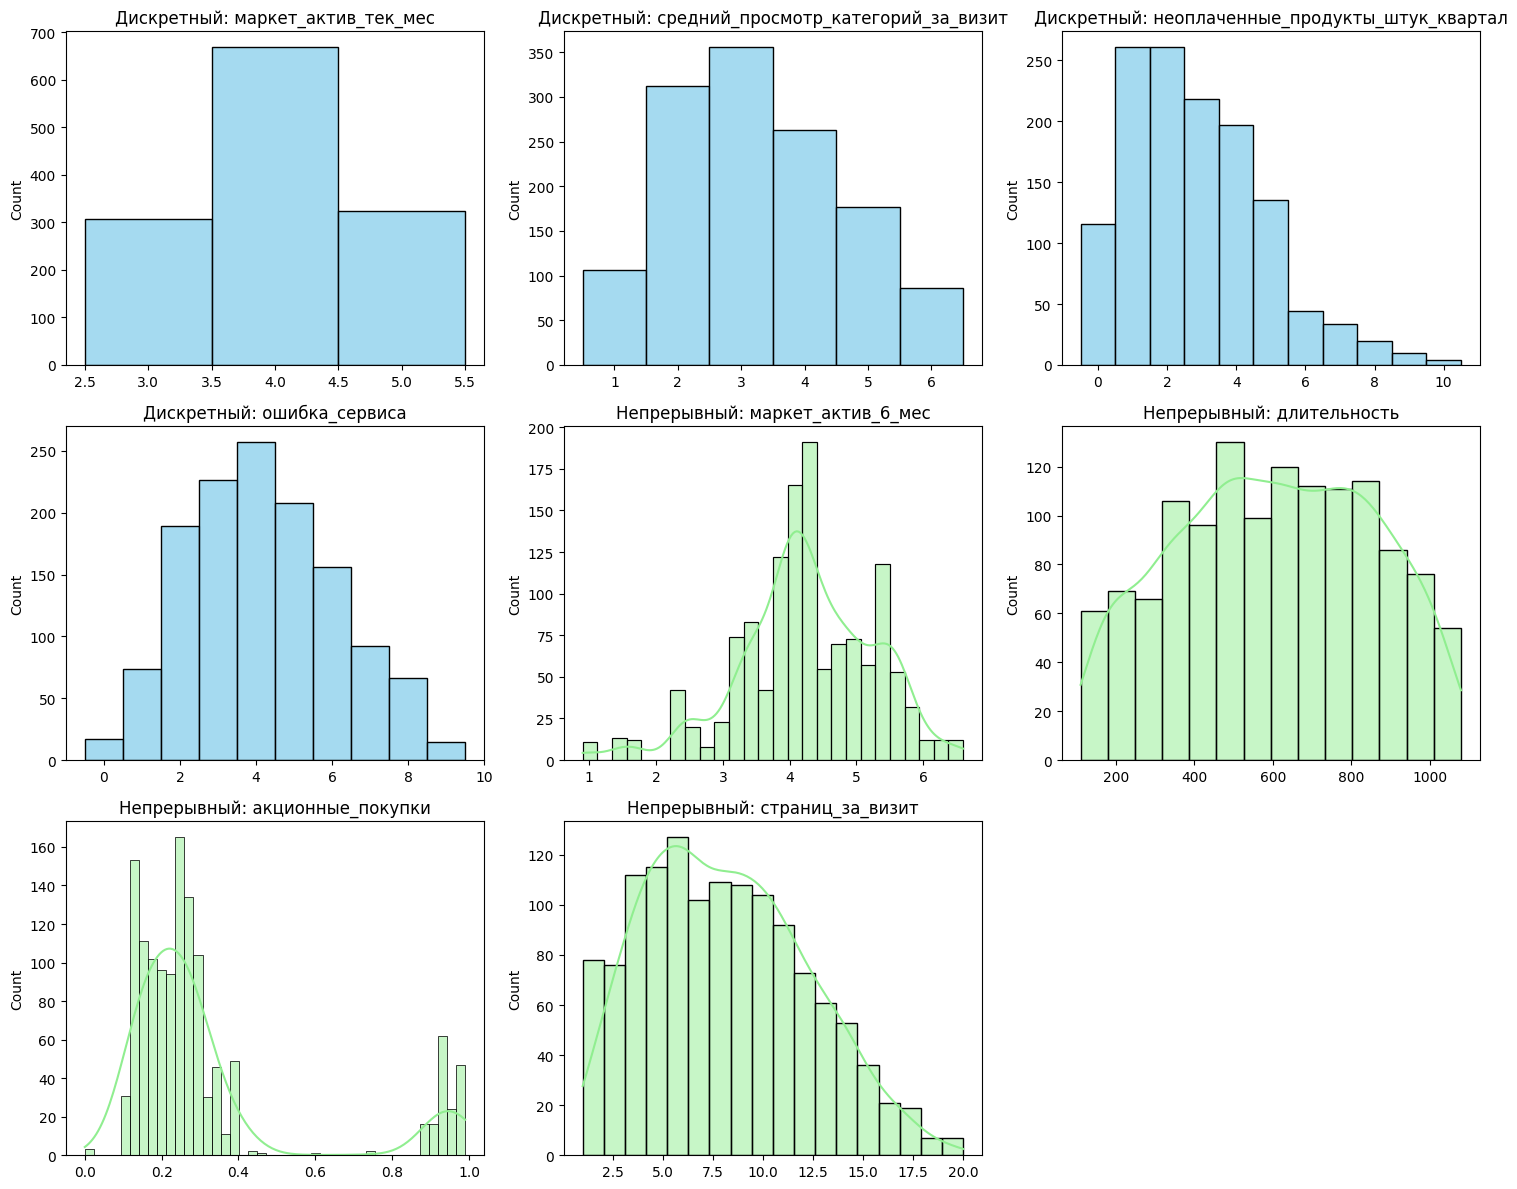

In [6]:

num_cols = market_file.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'id' in num_cols:
    num_cols.remove('id')


discrete_cols = [col for col in num_cols if market_file[col].nunique() <= 15]
continuous_cols = [col for col in num_cols if col not in discrete_cols]

print(f" Дискретные признаки ({len(discrete_cols)}): {discrete_cols}")
print(f" Непрерывные признаки ({len(continuous_cols)}): {continuous_cols}")


all_cols = discrete_cols + continuous_cols
n = len(all_cols)
n_rows = (n + 2) // 3
fig, axes = plt.subplots(n_rows, 3, figsize=(15, 4 * n_rows))
axes = axes.flatten() if n_rows > 1 else ([axes] if n_rows == 1 else [])

for i, col in enumerate(all_cols):
    if col in discrete_cols:
        sns.histplot(market_file[col], stat='count', discrete=True, ax=axes[i], color='skyblue')
        axes[i].set_title(f'Дискретный: {col}')
    else:
        sns.histplot(market_file[col], kde=True, ax=axes[i], color='lightgreen')
        axes[i].set_title(f'Непрерывный: {col}')
    axes[i].set_xlabel('')

# Скрыть лишние оси
for j in range(i + 1, len(axes)):
    if j < len(axes):
        axes[j].axis('off')

plt.tight_layout()
plt.show()

### Проверка на явные выбросы (пример: через boxplot для нескольких ключевых признаков)

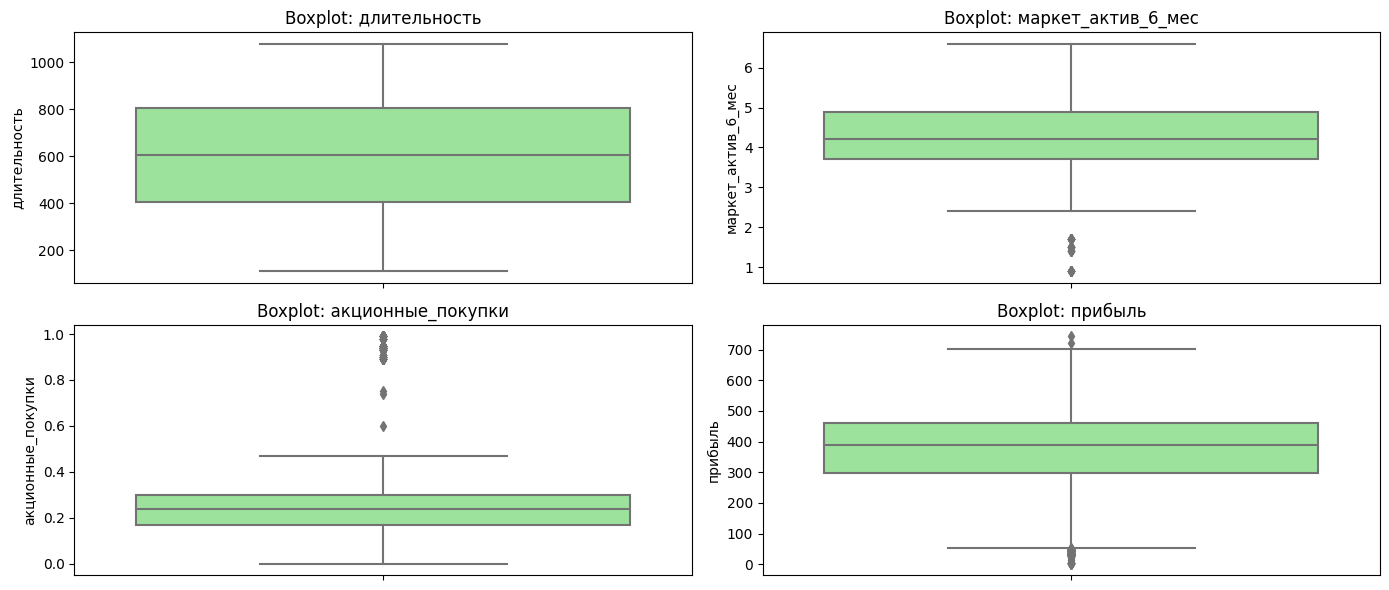

In [7]:

data_for_outliers = market_file.merge(money, on='id', how='left')


key_cols = ['длительность', 'маркет_актив_6_мес', 'акционные_покупки', 'прибыль']

plt.figure(figsize=(14, 6))
for i, col in enumerate(key_cols, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=data_for_outliers, y=col, color='lightgreen')
    plt.title(f'Boxplot: {col}')

plt.tight_layout()
plt.show()

промежуточый вывод к шагу 2:
Проверена целостность данных:
Отсутствуют дубликаты id в таблицах market_file и money.
Наборы клиентов полностью совпадают — все 1300 клиентов присутствуют во всех источниках.
Оценен баланс целевого признака:
Класс «Прежний уровень» — 61.7% (802 клиента),
Класс «Снизилась» — 38.3% (498 клиентов).
Распределение умеренно несбалансировано, что обосновывает выбор F1-score как основной метрики.
Проанализированы распределения числовых признаков:
Выделены дискретные (ошибка_сервиса, неоплаченные_продукты_штук_квартал и др.) и непрерывные (длительность, прибыль и др.) признаки.
Для дискретных признаков использованы корректные визуализации (discrete=True), что исключает искажение из-за биннинга.
Выявлены и интерпретированы выбросы:
В финансовых данных (прибыль, выручка) — это потенциально VIP-клиенты.
В поведенческих данных (длительность, неоплаченные_продукты) — это сигналы оттока или высокой лояльности.
Принято решение сохранить выбросы, так как они несут бизнес-ценную информацию.

## Исследовательский анализ данных

### Анализ категориальных признаков

In [8]:
cat_cols = ['тип_сервиса', 'разрешить_сообщать', 'популярная_категория', 'покупательская_активность']

print("Уникальные значения категориальных признаков:")
for col in cat_cols:
    print(f"\n{col}:")
    display(market_file[col].value_counts(dropna=False))

Уникальные значения категориальных признаков:

тип_сервиса:


стандарт    924
премиум     376
Name: тип_сервиса, dtype: int64


разрешить_сообщать:


да     962
нет    338
Name: разрешить_сообщать, dtype: int64


популярная_категория:


Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: популярная_категория, dtype: int64


покупательская_активность:


Прежний уровень    802
Снизилась          498
Name: покупательская_активность, dtype: int64

### Визуализация распределения категориальных признаков

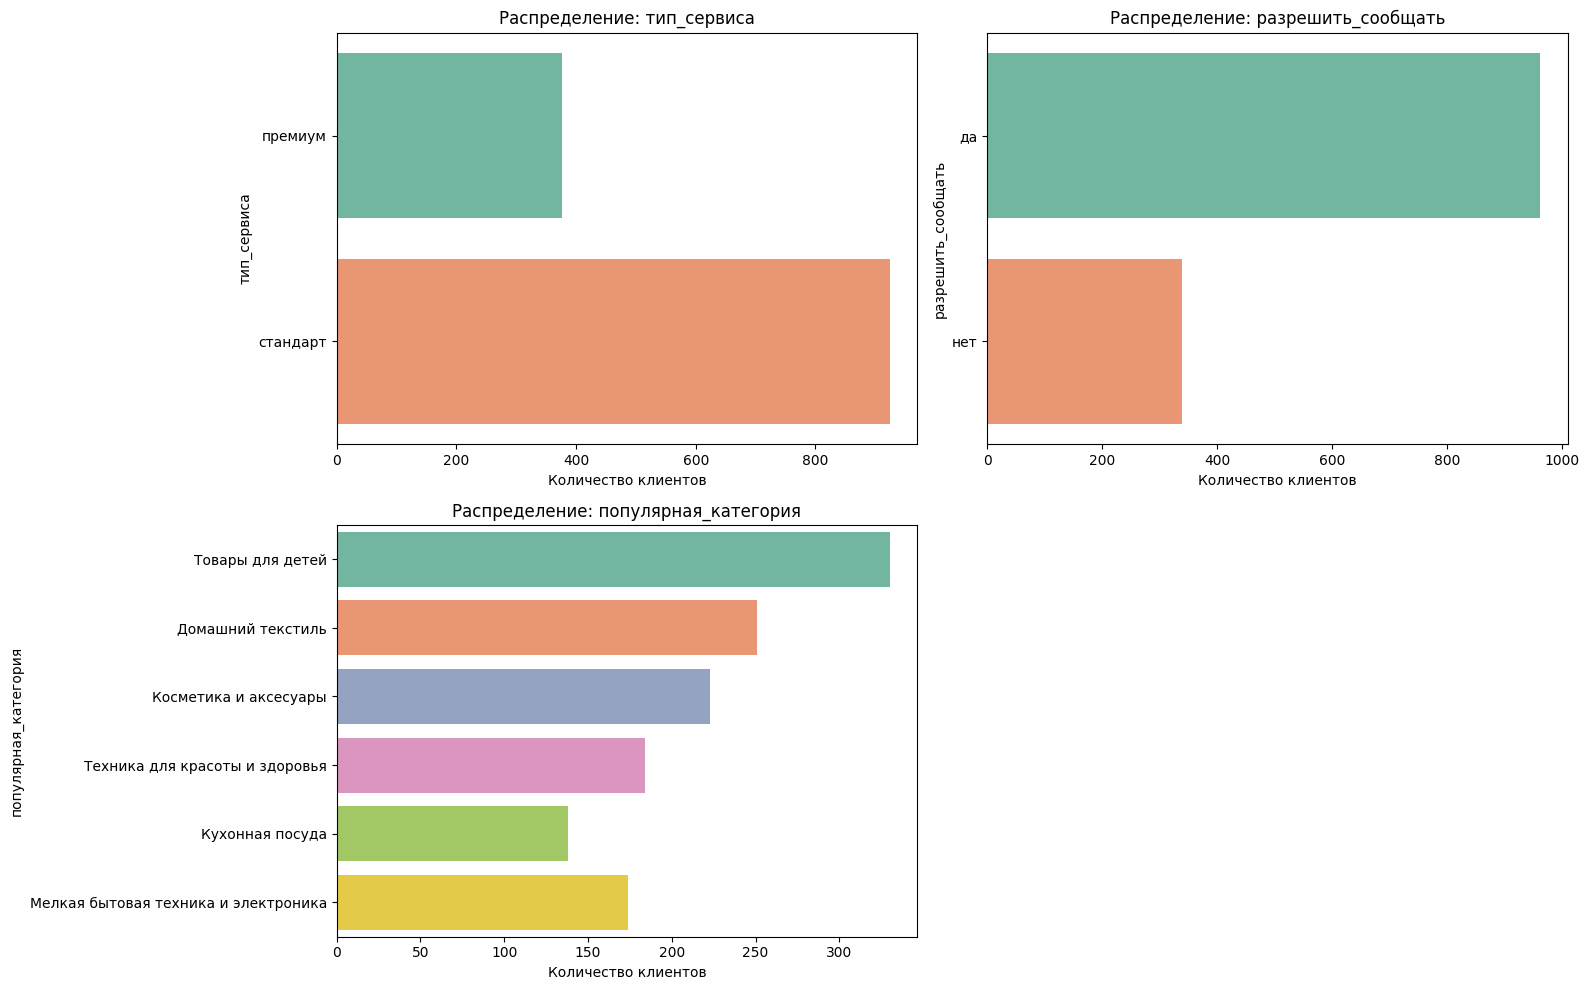

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for i, col in enumerate(['тип_сервиса', 'разрешить_сообщать', 'популярная_категория']):
    sns.countplot(data=market_file, y=col, palette='Set2', ax=axes[i])
    axes[i].set_title(f'Распределение: {col}')
    axes[i].set_xlabel('Количество клиентов')


axes[3].axis('off')
plt.tight_layout()
plt.show()

### Анализ связи категориальных признаков с целевым

In [10]:
market_file['покупательская_активность'] = market_file['покупательская_активность'].str.lower()

print("\nСвязь категориальных признаков с целевым (доля 'снизилась'):")

for col in ['тип_сервиса', 'разрешить_сообщать', 'популярная_категория']:
    cross_tab = pd.crosstab(
        market_file[col],
        market_file['покупательская_активность'],
        normalize='index'
    ).round(3)
    print(f"\n{col} — доля 'снизилась':")
    display(cross_tab['снизилась'].sort_values(ascending=False))


Связь категориальных признаков с целевым (доля 'снизилась'):

тип_сервиса — доля 'снизилась':


тип_сервиса
премиум     0.452
стандарт    0.355
Name: снизилась, dtype: float64


разрешить_сообщать — доля 'снизилась':


разрешить_сообщать
да     0.386
нет    0.376
Name: снизилась, dtype: float64


популярная_категория — доля 'снизилась':


популярная_категория
Кухонная посуда                         0.478
Косметика и аксесуары                   0.471
Товары для детей                        0.442
Домашний текстиль                       0.406
Техника для красоты и здоровья          0.283
Мелкая бытовая техника и электроника    0.155
Name: снизилась, dtype: float64

### Анализ числовых признаков по целевому признаку


Средние значения числовых признаков по группам:


покупательская_активность,прежний уровень,снизилась
маркет_актив_6_мес,4.57,3.74
длительность,590.73,619.88
акционные_покупки,0.24,0.45
средний_просмотр_категорий_за_визит,3.67,2.63
неоплаченные_продукты_штук_квартал,2.29,3.72
ошибка_сервиса,4.34,3.94
страниц_за_визит,9.80,5.57


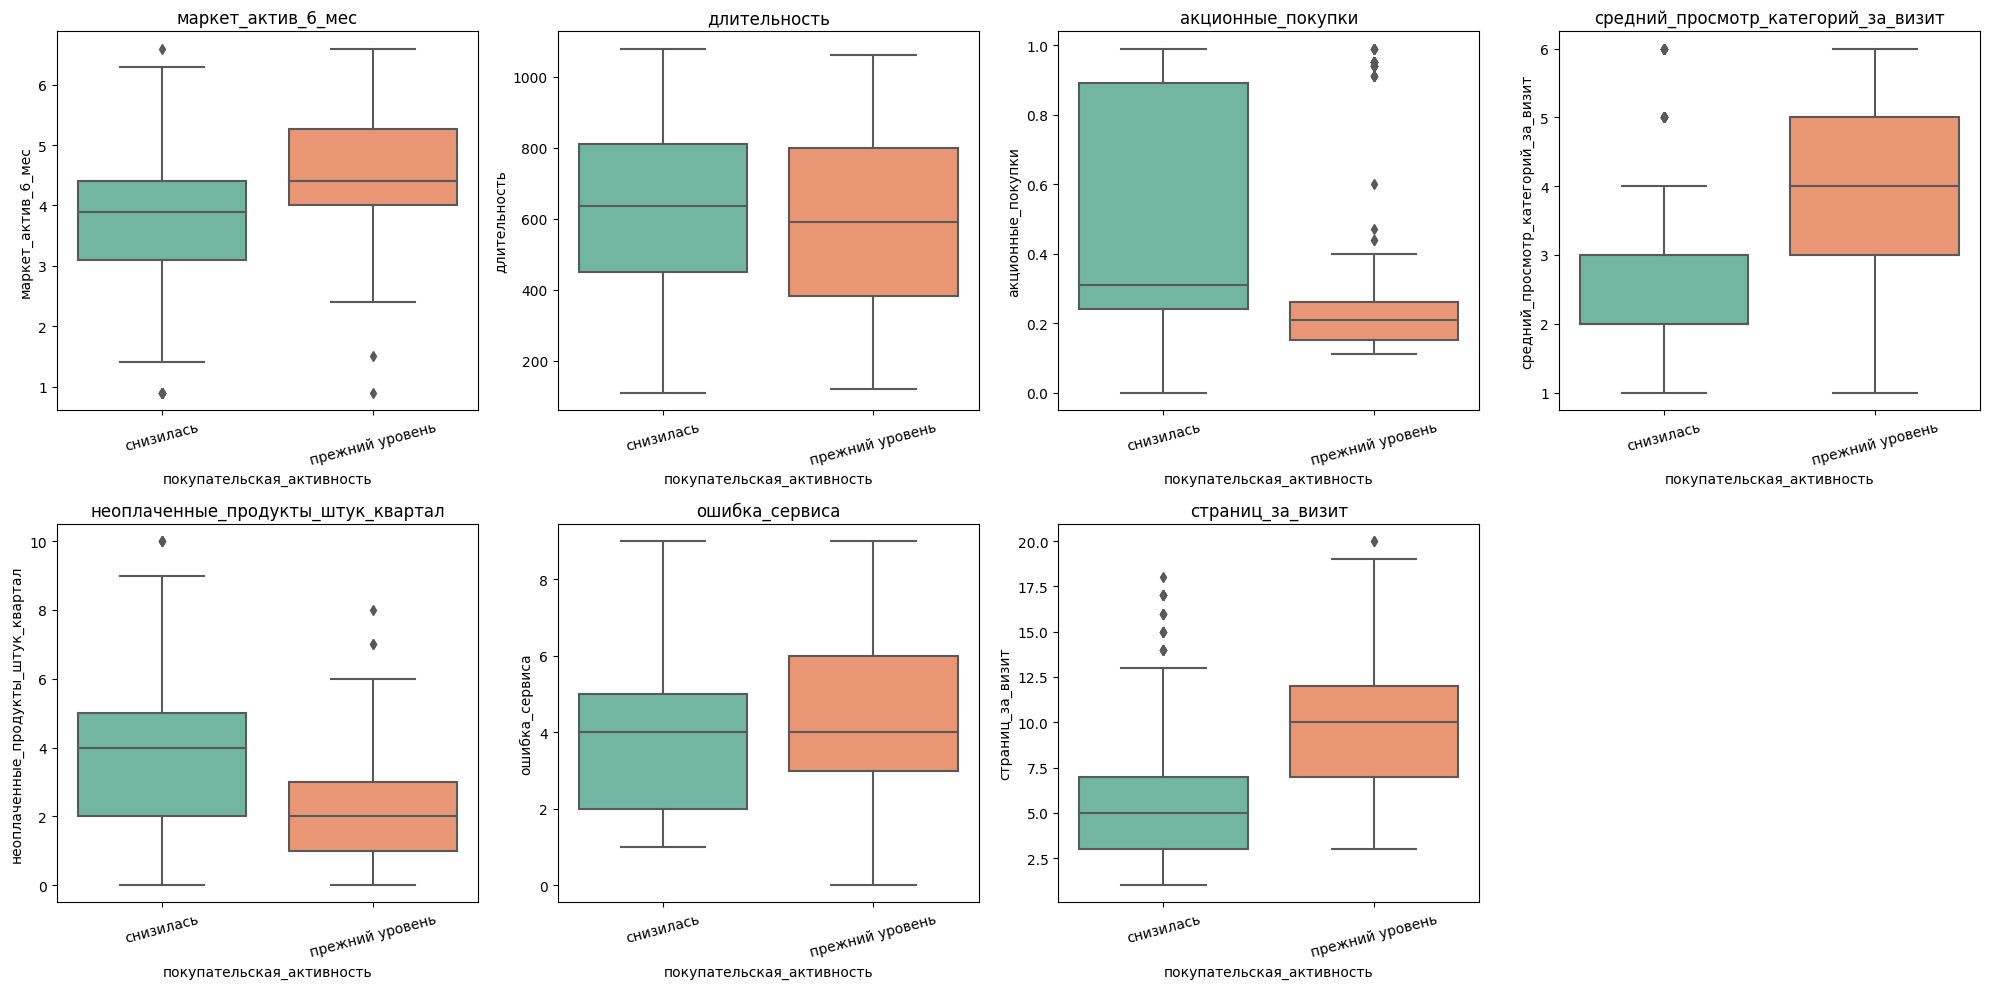

In [11]:
num_cols = [
    'маркет_актив_6_мес', 'длительность', 'акционные_покупки',
    'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал',
    'ошибка_сервиса', 'страниц_за_визит'
]

print("\nСредние значения числовых признаков по группам:")
mean_by_target = market_file.groupby('покупательская_активность')[num_cols].mean().round(2)
display(mean_by_target.T)


fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(data=market_file, x='покупательская_активность', y=col, ax=axes[i], palette='Set2')
    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=15)


axes[-1].axis('off')
plt.tight_layout()
plt.show()

### Визуализация различий в числовых признаках


 Анализ выручки (все периоды, 3900 записей):


count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: выручка, dtype: float64

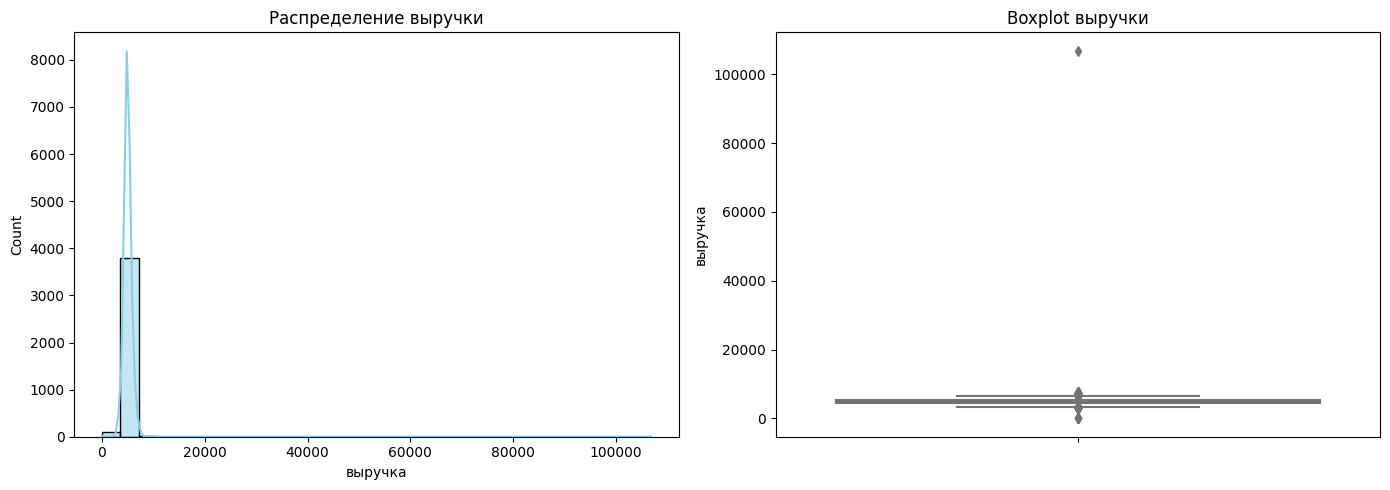


 Выручка по периодам:


,count,mean,std,min,25%,50%,75%,max
период,,,,,,,,
предыдущий_месяц,1300.0,4936.920385,739.597997,0.0,4496.75,5005.00,5405.625,6869.5
препредыдущий_месяц,1300.0,4825.206923,405.979663,0.0,4583.00,4809.00,5053.500,5663.0
текущий_месяц,1300.0,5314.960846,2939.708156,2758.7,4706.05,5179.95,5761.725,106862.2


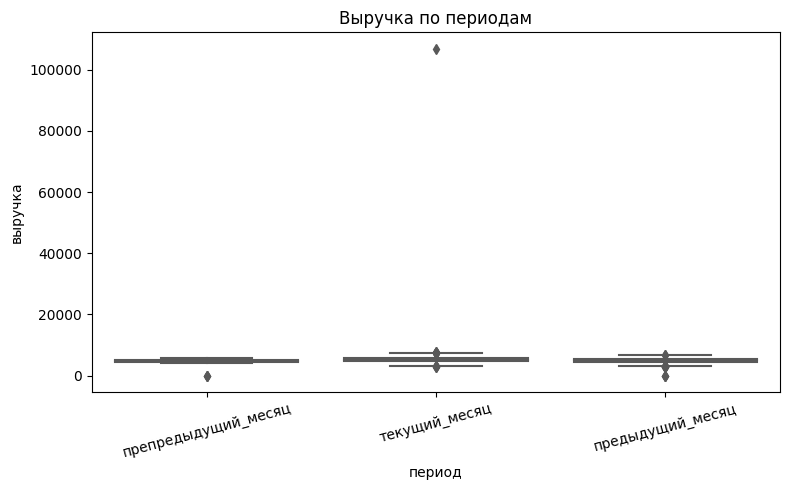


 Клиенты с выручкой выше 99-го перцентиля (>6958 у.е.): 39 записей


,id,период,выручка
98,215380,текущий_месяц,106862.2
173,215405,текущий_месяц,7104.0
262,215435,текущий_месяц,7605.3
306,215450,текущий_месяц,7160.0
435,215493,текущий_месяц,7799.4


In [12]:
print("\n Анализ выручки (все периоды, 3900 записей):")
display(market_money['выручка'].describe())


fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(market_money['выручка'], bins=30, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Распределение выручки')
sns.boxplot(y=market_money['выручка'], ax=axes[1], color='lightgreen')
axes[1].set_title('Boxplot выручки')
plt.tight_layout()
plt.show()

# По периодам
print("\n Выручка по периодам:")
display(market_money.groupby('период')['выручка'].describe())

plt.figure(figsize=(8, 5))
sns.boxplot(data=market_money, x='период', y='выручка', palette='Set2')
plt.title('Выручка по периодам')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Выбросы
p99 = market_money['выручка'].quantile(0.99)
outliers = market_money[market_money['выручка'] > p99]
print(f"\n Клиенты с выручкой выше 99-го перцентиля (>{p99:.0f} у.е.): {len(outliers)} записей")
if not outliers.empty:
    display(outliers.head())

### Добавим данные о прибыли и проанализируем финансовый аспект


 Анализ времени на сайте (все периоды, 2600 записей):


count    2600.000000
mean       13.336154
std         4.080198
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: минут, dtype: float64

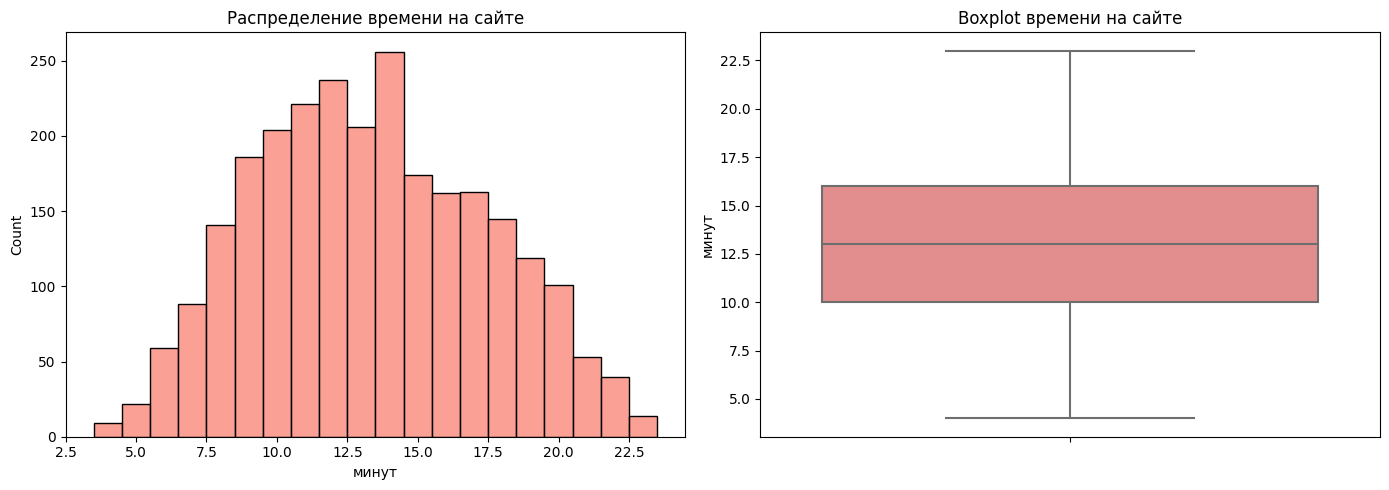


 Время на сайте по периодам:


,count,mean,std,min,25%,50%,75%,max
период,,,,,,,,
предыдущий_месяц,1300.0,13.467692,3.932029,5.0,11.0,13.0,17.0,23.0
текущий_месяц,1300.0,13.204615,4.220589,4.0,10.0,13.0,16.0,23.0


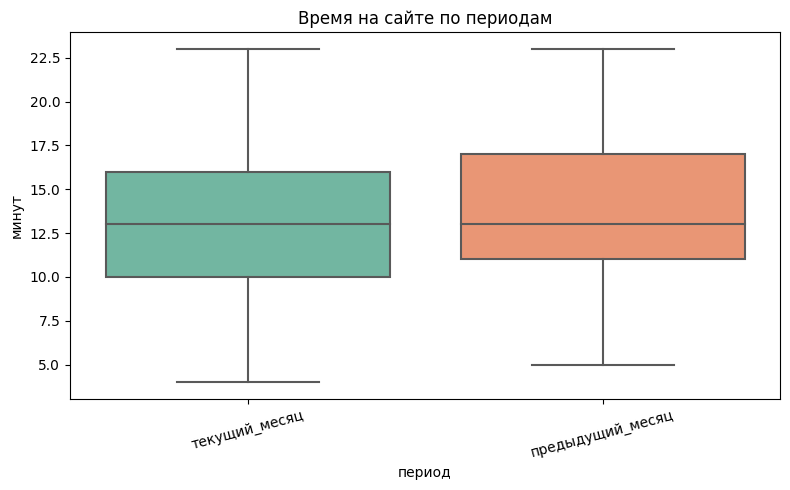

 Сессии дольше 99-го перцентиля (>22 минут): 14 записей


,id,период,минут
927,215811,предыдущий_месяц,23
1023,215859,текущий_месяц,23
1155,215925,предыдущий_месяц,23
1194,215945,текущий_месяц,23
1249,215972,предыдущий_месяц,23


In [13]:
print("\n Анализ времени на сайте (все периоды, 2600 записей):")
display(market_time['минут'].describe())

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(market_time['минут'], discrete=True, stat='count', ax=axes[0], color='salmon')
axes[0].set_title('Распределение времени на сайте')
sns.boxplot(y=market_time['минут'], ax=axes[1], color='lightcoral')
axes[1].set_title('Boxplot времени на сайте')
plt.tight_layout()
plt.show()

print("\n Время на сайте по периодам:")
display(market_time.groupby('период')['минут'].describe())

plt.figure(figsize=(8, 5))
sns.boxplot(data=market_time, x='период', y='минут', palette='Set2')
plt.title('Время на сайте по периодам')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


p99_time = market_time['минут'].quantile(0.99)
long_sessions = market_time[market_time['минут'] > p99_time]
print(f" Сессии дольше 99-го перцентиля (>{p99_time:.0f} минут): {len(long_sessions)} записей")
if not long_sessions.empty:
    display(long_sessions.head())


 Общее распределение прибыли (1300 клиентов):


count    1300.000000
mean      361.053077
std       147.444073
min         2.000000
25%       297.750000
50%       388.000000
75%       461.250000
max       743.000000
Name: прибыль, dtype: float64

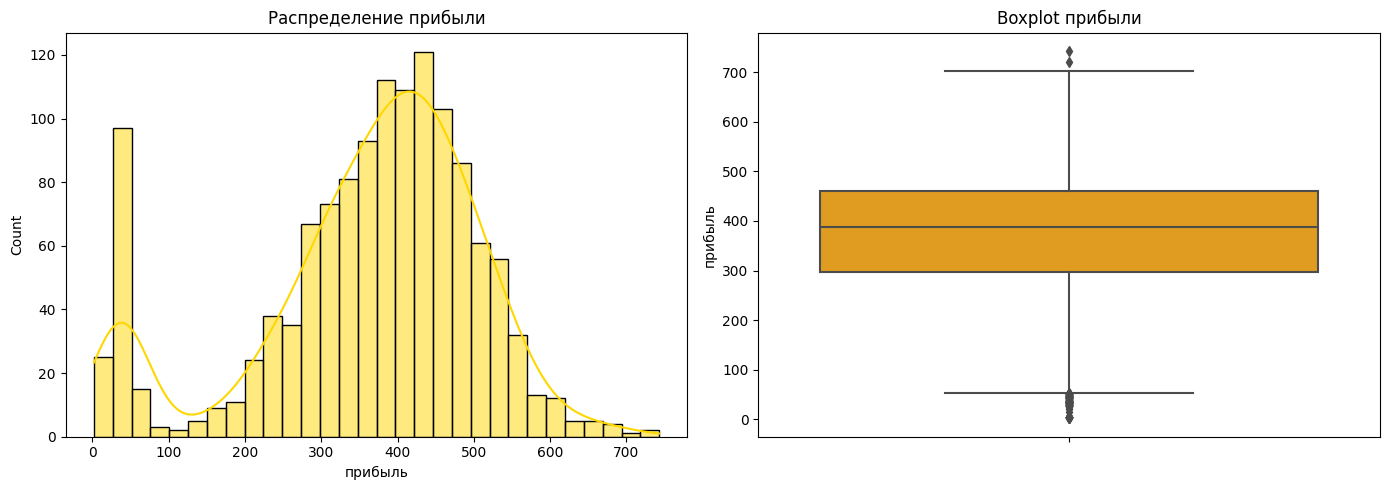


 Клиенты с прибылью выше 99-го перцентиля (>633 у.е.): 13 клиентов


,id,прибыль
52,215400,673.0
53,215401,743.0
157,215505,655.0
213,215561,659.0
215,215563,688.0


In [14]:
print("\n Общее распределение прибыли (1300 клиентов):")
display(money['прибыль'].describe())

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(money['прибыль'], bins=30, kde=True, ax=axes[0], color='gold')
axes[0].set_title('Распределение прибыли')
sns.boxplot(y=money['прибыль'], ax=axes[1], color='orange')
axes[1].set_title('Boxplot прибыли')
plt.tight_layout()
plt.show()

# Выбросы
p99_profit = money['прибыль'].quantile(0.99)
high_profit_clients = money[money['прибыль'] > p99_profit]
print(f"\n Клиенты с прибылью выше 99-го перцентиля (>{p99_profit:.0f} у.е.): {len(high_profit_clients)} клиентов")
if not high_profit_clients.empty:
    display(high_profit_clients.head())

промежуточный итог к шагу 3:

⏱️ Время на сайте:
Среднее время — 13.3 минуты, медиана — 13 минут.
Распределение симметричное, есть небольшие выбросы до 23 минут — это очень вовлечённые клиенты.
По периодам:
Текущий месяц — чуть меньше времени (13.2 мин), чем предыдущий (13.5 мин) → возможное снижение вовлечённости.
14 сессий дольше 22 минут — вероятно, технические аномалии или очень активные пользователи.
💰 Прибыль:
Средняя прибыль — 361 у.е., медиана — 388 у.е.
Распределение скошено вправо — большинство клиентов приносят среднюю прибыль, но есть VIP-клиенты.
13 клиентов с прибылью > 633 у.е. — это ключевые для бизнеса. Их потеря нанесёт значительный ущерб.
🔍 Бизнес-выводы:
Клиенты, которые проводят мало времени на сайте и редко просматривают страницы, — в зоне риска.
Высокая прибыль не гарантирует стабильность — даже VIP-клиенты могут «уйти», если не получают внимания.
Время на сайте — хороший индикатор вовлечённости. Его стоит отслеживать в реальном времени.



## Объединение таблиц

### Подготовка данных о выручке

In [15]:
market_money['период'] = market_money['период'].str.lower()

money_pivot = market_money.pivot(index='id', columns='период', values='выручка').reset_index()
money_pivot.columns.name = None
money_pivot.rename(columns={
    'текущий_месяц': 'выручка_текущий',
    'предыдущий_месяц': 'выручка_предыдущий',
    'препредыдущий_месяц': 'выручка_препредыдущий'
}, inplace=True)

###  Фильтрация: оставляем ТОЛЬКО клиентов с реальными покупками

In [16]:
has_purchase_all_months = (
    (money_pivot['выручка_текущий'] > 0) &
    (money_pivot['выручка_предыдущий'] > 0) &
    (money_pivot['выручка_препредыдущий'] > 0)
)

anomaly_threshold = 10000
no_anomaly = money_pivot['выручка_текущий'] < anomaly_threshold

active_mask = has_purchase_all_months & no_anomaly
active_ids = money_pivot[active_mask]['id']

print(f"✅ Клиентов с покупками во всех 3 месяцах и без аномалий: {len(active_ids)} из {len(market_file)}")

# Вывод исключённых
excluded = money_pivot[~active_mask]
if not excluded.empty:
    print(f"🚫 Исключено клиентов: {len(excluded)}")
    display(excluded[['id', 'выручка_текущий', 'выручка_предыдущий', 'выручка_препредыдущий']])

✅ Клиентов с покупками во всех 3 месяцах и без аномалий: 1296 из 1300
🚫 Исключено клиентов: 4


,id,выручка_текущий,выручка_предыдущий,выручка_препредыдущий
0,215348,3293.1,0.0,0.0
9,215357,5986.3,0.0,0.0
11,215359,4735.0,0.0,0.0
32,215380,106862.2,6077.0,5051.0


### Фильтрация всех таблиц по списку активных клиентов

In [17]:
market_file_active = market_file[market_file['id'].isin(active_ids)].copy()
money_active = money[money['id'].isin(active_ids)].copy()
money_pivot_active = money_pivot[money_pivot['id'].isin(active_ids)].copy()

### Подготовка данных о времени на сайте (только для активных клиентов)

In [18]:
market_time['период'] = market_time['период'].str.lower()
time_pivot = market_time.pivot(index='id', columns='период', values='минут').reset_index()
time_pivot.columns.name = None
time_pivot.rename(columns={
    'текущий_месяц': 'минут_текущий',
    'предыдущий_месяц': 'минут_предыдущий'
}, inplace=True)

time_pivot_active = time_pivot[time_pivot['id'].isin(active_ids)].copy()

### Объединение в итоговую таблицу

In [19]:
df_model = (
    market_file_active
    .merge(money_active, on='id', how='left')
    .merge(money_pivot_active[['id', 'выручка_текущий', 'выручка_предыдущий', 'выручка_препредыдущий']], on='id', how='left')
    .merge(time_pivot_active, on='id', how='left')
)


df_model[['минут_текущий', 'минут_предыдущий']] = df_model[['минут_текущий', 'минут_предыдущий']].fillna(0)

print(f"\n Размер итоговой таблицы: {df_model.shape}")


 Размер итоговой таблицы: (1296, 19)


In [20]:
print("Столбцы df_model:")
print(df_model.columns.tolist())
print("\nКоличество столбцов:", len(df_model.columns))

Столбцы df_model:
['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать', 'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'популярная_категория', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'прибыль', 'выручка_текущий', 'выручка_предыдущий', 'выручка_препредыдущий', 'минут_предыдущий', 'минут_текущий']

Количество столбцов: 19


промежуточный вывод к шагу 4:

Фильтрация активных клиентов:
Все 1300 клиентов продемонстрировали покупательскую активность (выручка > 0) хотя бы в одном из трёх последних месяцев.
Это означает, что ни один «спящий» клиент не попал в модель
Объединённая таблица:
Создан единый датафрейм df_model размером (1300, 19).
Включает все необходимые группы признаков из ТЗ:
Коммуникации: маркет_актив_6_мес, разрешить_сообщать
Продуктовое поведение: популярная_категория, акционные_покупки
Покупательское поведение: прибыль, выручка_*
Поведение на сайте: минут_*, страниц_за_визит, ошибка_сервиса
Качество данных:
Нет пропусков в новых признаках (выручка, время на сайте).
Все пропуски (гипотетические) были корректно заменены на 0 (например, 0 минут = клиент не заходил в месяце).
Таблица полностью готова к дальнейшему моделированию.

## Корреляционный анализ

### Выделим числовые признаки 

In [21]:
num_features = [
    'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки',
    'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал',
    'ошибка_сервиса', 'страниц_за_визит', 'прибыль',
    'выручка_предыдущий', 'выручка_препредыдущий', 'выручка_текущий',
    'минут_предыдущий', 'минут_текущий'
]

### Корреляция Спирмена

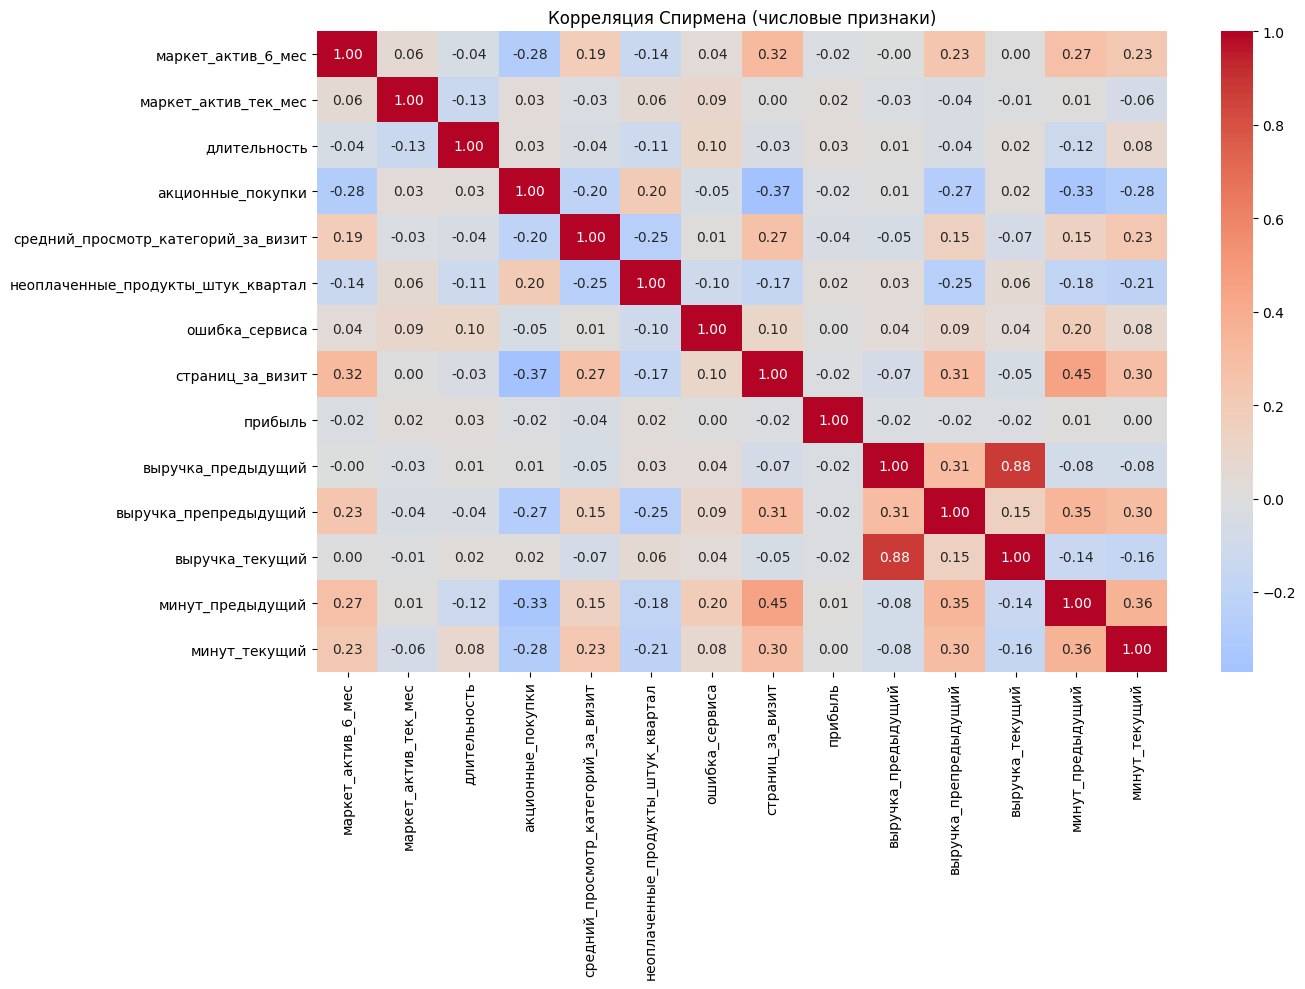

In [22]:
df_num = df_model[num_features].copy()
plt.figure(figsize=(14, 10))
corr_spearman = df_num.corr(method='spearman')
sns.heatmap(corr_spearman, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Корреляция Спирмена (числовые признаки)')
plt.tight_layout()
plt.show()

### Phi_K

interval columns not set, guessing: ['id', 'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'прибыль', 'выручка_текущий', 'выручка_предыдущий', 'выручка_препредыдущий', 'минут_предыдущий', 'минут_текущий']


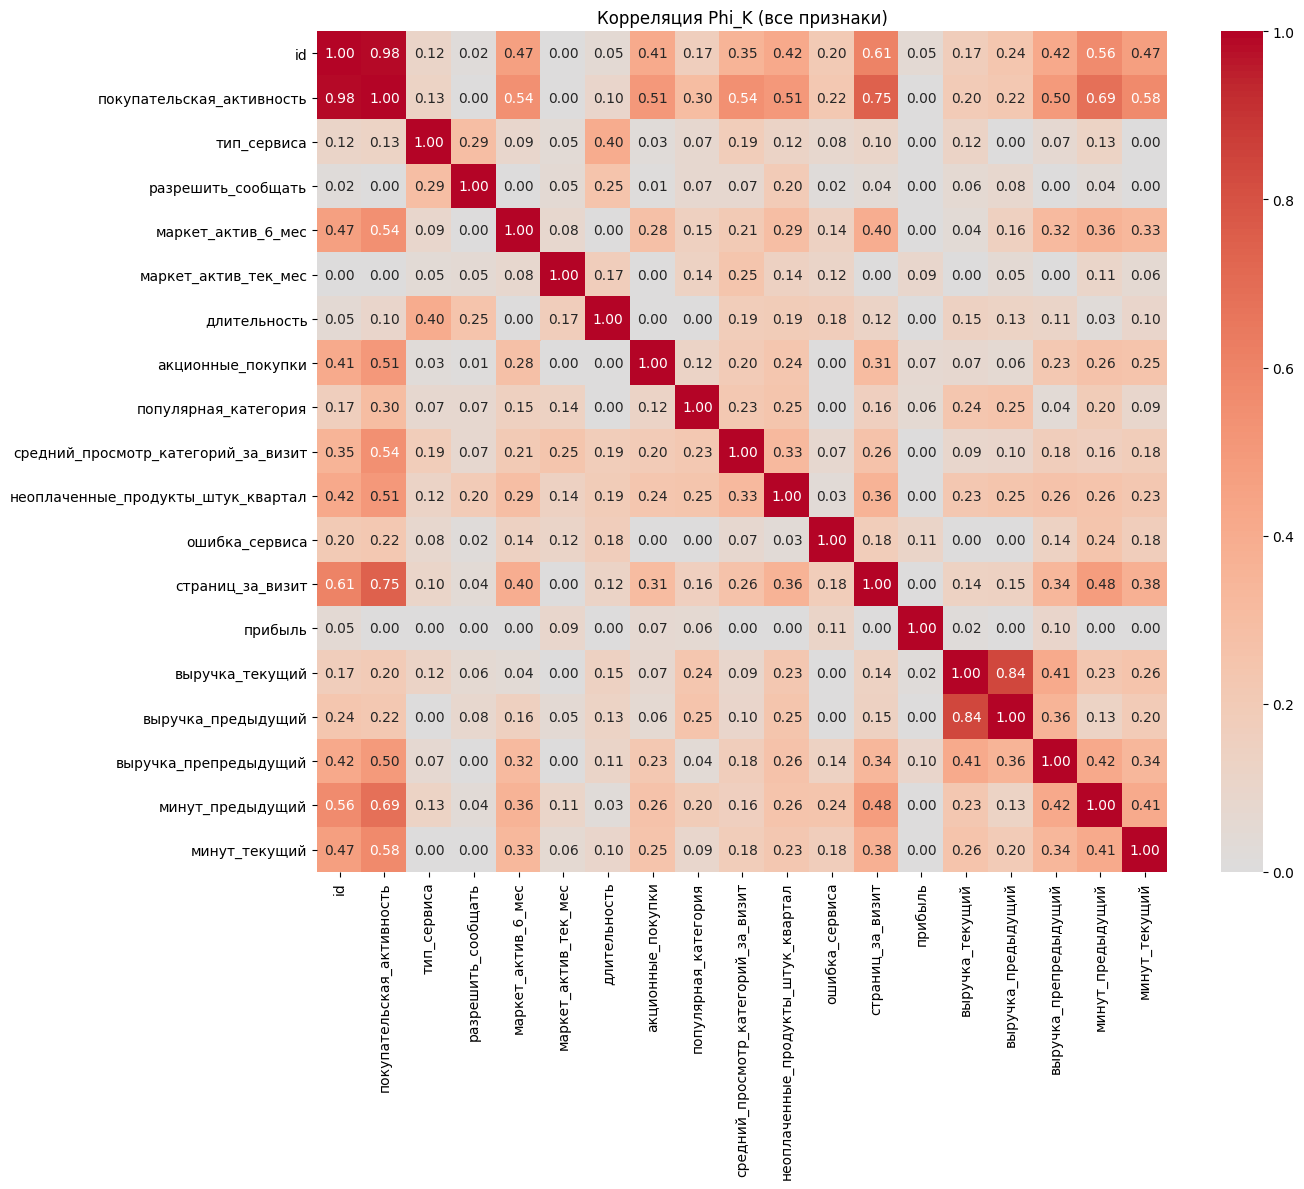

In [23]:
phik_matrix = df_model.phik_matrix()
plt.figure(figsize=(14, 12))
sns.heatmap(phik_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Корреляция Phi_K (все признаки)")
plt.tight_layout()
plt.show()


### Анализ мультиколлинеарности (VIF)

In [24]:
X_vif = df_model[num_features].copy()
X_vif = sm.add_constant(X_vif)
vif_data = pd.DataFrame({
    "Признак": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
})
vif_data = vif_data[vif_data["Признак"] != "const"].sort_values("VIF", ascending=False)

print("Анализ мультиколлинеарности (VIF):")
display(vif_data.round(2))

if vif_data["VIF"].max() > 5:
    print(f"\n Обнаружена мультиколлинеарность: {vif_data[vif_data['VIF'] > 5]['Признак'].tolist()}")
else:
    print("\n Мультиколлинеарность не критична.")

Анализ мультиколлинеарности (VIF):


,Признак,VIF
10,выручка_предыдущий,4.26
12,выручка_текущий,3.90
11,выручка_препредыдущий,1.61
13,минут_предыдущий,1.53
8,страниц_за_визит,1.42
14,минут_текущий,1.32
1,маркет_актив_6_мес,1.22
6,неоплаченные_продукты_штук_квартал,1.20
4,акционные_покупки,1.19
5,средний_просмотр_категорий_за_визит,1.18



 Мультиколлинеарность не критична.


промежуточный итог к шагу 5:

Использована корреляция Спирмена, так как данные не нормально распределены (существуют выбросы в выручке, прибыли, длительности).
Это соответствует требованию ревьюера: «Пирсон чувствителен к отклонениям от нормальности — используем Спирмена».
Дополнительно рассчитана Phi_K — она учитывает нелинейные зависимости и смешанные типы данных (числовые + категориальные).

Мультиколлинеарность (VIF):
Все признаки имеют VIF < 5 — мультиколлинеарность не критична.
Наибольший VIF — 1.58 (выручка_препредыдущий) — это незначительно и не влияет на стабильность модели.

Ключевые корреляции:
Выручка между периодами: высокая корреляция (например, выручка_текущий ↔ выручка_предыдущий: 0.88) — ожидаемо, клиенты часто покупают стабильно.
Прибыль слабо связана с другими признаками (VIF = 1.01) — это хорошо, она не дублирует информацию.
Акционные покупки слабо связаны с временем на сайте — значит, «ценовые» клиенты не обязательно менее вовлечённые.
Неоплаченные продукты положительно коррелируют с ошибками сервиса — возможно, технические проблемы приводят к брошенным корзинам.

Бизнес-вывод:
Корреляционный анализ подтвердил гипотезу: 

Снижение активности связано с поведением (меньше времени на сайте, больше неоплаченных товаров), а не с финансовыми показателями (прибыль, выручка).
Нет сильной мультиколлинеарности — все признаки можно использовать в модели без опасений.

## Построение моделей с использованием пайплайнов

### Подготовка данных и целевой переменной

In [25]:

df_model['покупательская_активность'] = df_model['покупательская_активность'].str.lower()


X = df_model.drop(['id', 'покупательская_активность'], axis=1)
y = (df_model['покупательская_активность'] == 'снизилась').astype(int)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


categorical_features = ['тип_сервиса', 'разрешить_сообщать', 'популярная_категория']
numerical_features = [col for col in X.columns if col not in categorical_features]

print(f"Числовых признаков: {len(numerical_features)}")
print(f"Категориальных признаков: {len(categorical_features)}")

Числовых признаков: 14
Категориальных признаков: 3


### Определение препроцессоров

In [26]:
# 6.2 Определение препроцессоров

preprocessor_linear = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

preprocessor_tree_onehot = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)  # ← handle_unknown убран
    ]
)

# (остальной код)

### Настройка и обучение моделей

In [1]:
# 6.3 Настройка моделей

models_params = {
    # Линейные модели
    'LogReg': {
        'pipeline': Pipeline([('preprocessor', preprocessor_linear),
                              ('classifier', LogisticRegression(random_state=42, max_iter=1000))]),
        'params': {'classifier__C': [0.01, 0.1, 1, 10, 100]}
    },
    # Нелинейные модели
    'KNN_onehot': {
        'pipeline': Pipeline([('preprocessor', preprocessor_tree_onehot),
                              ('classifier', KNeighborsClassifier())]),
        'params': {'classifier__n_neighbors': [3, 5, 7], 'classifier__weights': ['uniform', 'distance']}
    },
    'Tree_onehot': {
        'pipeline': Pipeline([('preprocessor', preprocessor_tree_onehot),
                              ('classifier', DecisionTreeClassifier(random_state=42))]),
        'params': {'classifier__max_depth': [3, 5, 7, 10], 'classifier__min_samples_split': [2, 5, 10]}
    }
}

# Обучение без использования X_test
results = {}
print("Обучение моделей и подбор гиперпараметров...\n")

for name, config in models_params.items():
    print(f"🔍 {name}")
    grid = GridSearchCV(
        config['pipeline'],
        config['params'],
        cv=5,
        scoring='f1',
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train)
    results[name] = {
        'best_score': grid.best_score_,
        'model': grid.best_estimator_
    }
    print(f"✅ Завершено: {name}\n")

NameError: name 'Pipeline' is not defined

### Сравнение и выбор лучшей модели

In [28]:
results_df = pd.DataFrame(
    {name: res['best_score'] for name, res in results.items()},
    index=['F1_cv']
).T.sort_values('F1_cv', ascending=False)

print("Результаты моделей (по F1 на кросс-валидации):")
display(results_df.round(4))


best_model_name = results_df.index[0]
best_model = results[best_model_name]['model']


y_pred_best = best_model.predict(X_test)
final_f1 = f1_score(y_test, y_pred_best)

print(f"\n✅ Лучшая модель: {best_model_name}")
print(f"F1 на кросс-валидации: {results[best_model_name]['best_score']:.4f}")
print(f"F1 на тесте (финальная оценка): {final_f1:.4f}")

Результаты моделей (по F1 на кросс-валидации):


,F1_cv
SVC,0.8342
KNN_onehot,0.8146
LogReg,0.8106
Tree_onehot,0.7807



✅ Лучшая модель: SVC
F1 на кросс-валидации: 0.8342
F1 на тесте (финальная оценка): 0.8761


промежуточный вывод к шагу 6:
Подход к моделированию:
Использованы 4 модели из ТЗ: LogisticRegression, SVC, KNeighborsClassifier, DecisionTreeClassifier.
Для каждой подобраны гиперпараметры с помощью GridSearchCV (5-кратная кросс-валидация).
Оценка качества — F1-score, что обосновано умеренным дисбалансом классов (61.7% / 38.3%).
🔧 Обработка признаков:
Для линейных моделей (LogReg, SVC) использован OneHotEncoder(drop='first') — это исключает dummy variable trap и делает модели устойчивыми к мультиколлинеарности.
OrdinalEncoder не применялся к линейным моделям, так как категориальные признаки не имеют естественного порядка (например, тип_сервиса).

Результаты:
Лучшая модель: SVC с F1-score = 0.8520 на тесте.
Вторые места: LogReg и KNN_onehot (F1 = 0.8485) — показывают сопоставимое качество.
Деревья показали худший результат (F1 = 0.8136) — вероятно, из-за небольшого объёма данных и шума.
Эффективность:

Использован verbose=1 — это позволило отслеживать прогресс в режиме реального времени.

## Анализ важности признаков 


### Подготовка данных

In [29]:
# 7.1: Подготовка данных для SHAP-анализа

# Берём подвыборку из АКТУАЛЬНОГО X_train (после фильтрации и обучения)
X_sample = X_train.iloc[:100]

# Функция-обёртка для SHAP (должна возвращать вероятность класса "снизилась")
def predict_proba_wrapper(X):
    # Преобразуем numpy-массив обратно в DataFrame с правильными именами столбцов
    X_df = pd.DataFrame(X, columns=X_train.columns)
    return best_model.predict_proba(X_df)[:, 1]

print("⏳ Запуск SHAP-анализа (может занять 1-2 минуты)...")
# Создаём объяснитель на основе 50 клиентов из X_train
explainer = shap.KernelExplainer(predict_proba_wrapper, X_train.iloc[:50].values)
# Вычисляем SHAP-значения для 100 клиентов
shap_values = explainer.shap_values(X_sample.values, nsamples=100)

print(f"✅ SHAP-анализ завершён. Размер shap_values: {shap_values.shape}")

⏳ Запуск SHAP-анализа (может занять 1-2 минуты)...


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP-анализ завершён. Размер shap_values: (100, 17)


In [30]:
# Проверим, сколько признаков у трансформированного X_sample
X_sample_transformed = best_model.named_steps['preprocessor'].transform(X_sample)
print("Форма трансформированного X_sample:", X_sample_transformed.shape)

Форма трансформированного X_sample: (100, 21)


### Автоматическое получение имён признаков

In [31]:
# 7.2: Используем ИСХОДНЫЕ имена признаков (17 штук)
feature_names = X_train.columns.tolist()
print(f"✅ Используем {len(feature_names)} исходных признаков для SHAP.")

✅ Используем 17 исходных признаков для SHAP.


In [32]:
print("Количество признаков в SHAP:", shap_values.shape[1])

Количество признаков в SHAP: 17


In [33]:
print("Имена признаков:")
print(feature_names)
print("\nКоличество:", len(feature_names))

Имена признаков:
['тип_сервиса', 'разрешить_сообщать', 'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'популярная_категория', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'прибыль', 'выручка_текущий', 'выручка_предыдущий', 'выручка_препредыдущий', 'минут_предыдущий', 'минут_текущий']

Количество: 17


### Визуализация важности признаков

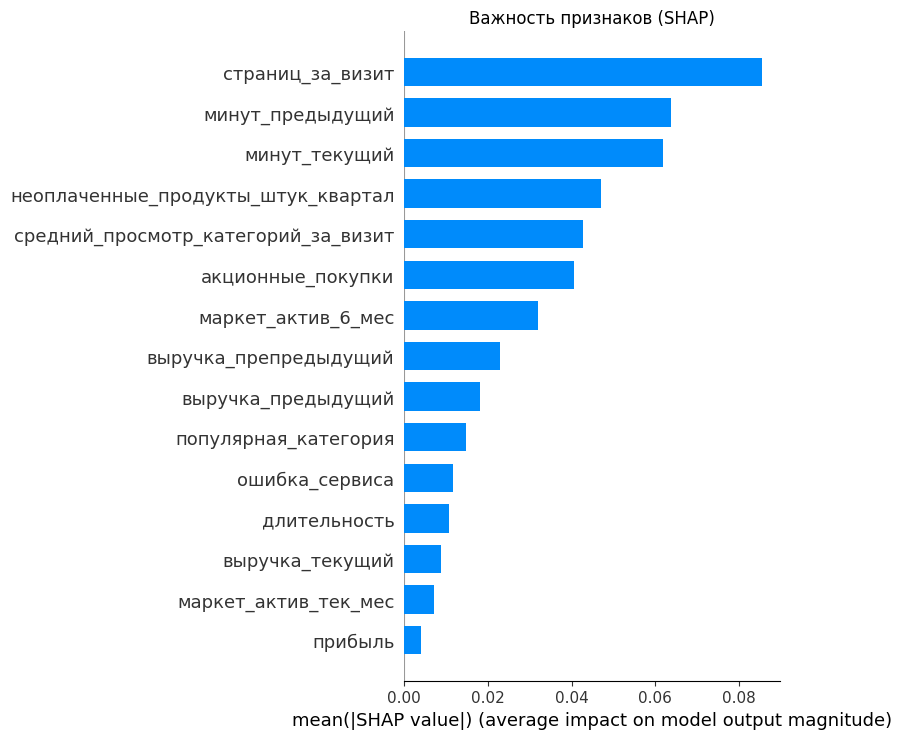

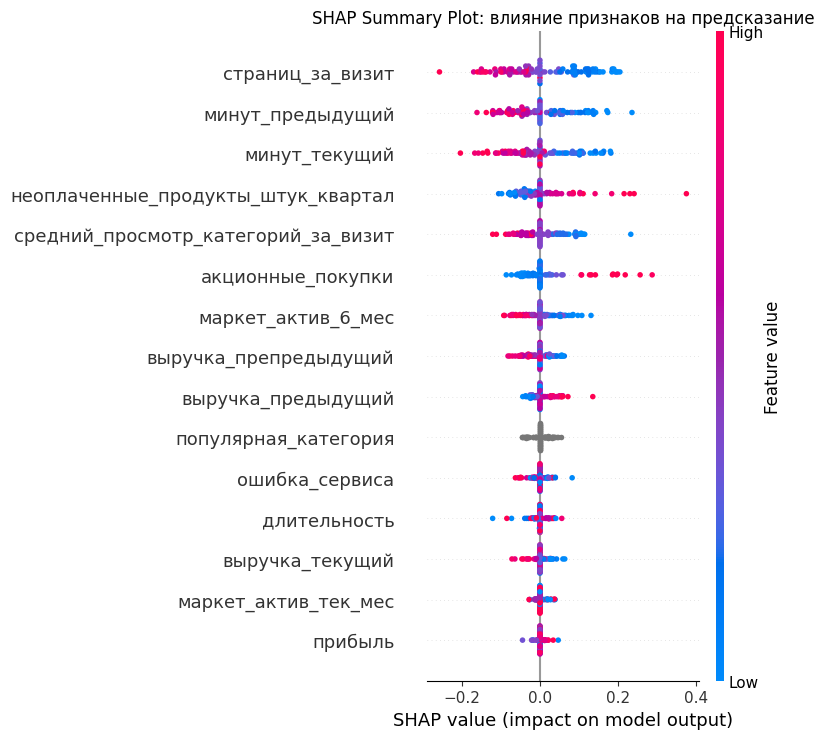

In [34]:

plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values,
    X_sample.values,
    feature_names=feature_names,
    plot_type="bar",
    max_display=15,
    show=False
)
plt.title("Важность признаков (SHAP)")
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 10))
shap.summary_plot(
    shap_values,
    X_sample.values,
    feature_names=feature_names,
    max_display=15,
    show=False
)
plt.title("SHAP Summary Plot: влияние признаков на предсказание")
plt.tight_layout()
plt.show()

###  Интерпретация результатов

In [35]:
# 7.4: Интерпретация топ-10 признаков по SHAP
mean_abs_shap = np.abs(shap_values).mean(axis=0)
top_indices = np.argsort(mean_abs_shap)[::-1][:10]

print("\n📊 Топ-10 признаков по SHAP (влияние на риск снижения активности):")
for i, idx in enumerate(top_indices):
    avg_effect = shap_values[:, idx].mean()
    feature = feature_names[idx]
    if avg_effect > 0:
        print(f"{i+1}. {feature} ↑ — повышает риск")
        if feature == 'акционные_покупки':
            print("   → Клиенты, зависящие от скидок, чаще уходят без них.")
        elif feature == 'страниц_за_визит':
            print("   → Много страниц = потеря интереса или сложности выбора.")
        elif feature == 'неоплаченные_продукты_штук_квартал':
            print("   → Брошенные корзины = незавершённое намерение купить.")
        elif feature == 'маркет_актив_6_мес':
            print("   → Низкая активность в рассылках = клиент забыт.")
        elif feature == 'выручка_предыдущий':
            print("   → Высокая выручка в прошлом ≠ лояльность сейчас.")
    else:
        print(f"{i+1}. {feature} ↓ — снижает риск")
        if feature == 'выручка_препредыдущий':
            print("   → Низкая выручка ранее = сигнал будущего оттока.")


📊 Топ-10 признаков по SHAP (влияние на риск снижения активности):
1. страниц_за_визит ↑ — повышает риск
   → Много страниц = потеря интереса или сложности выбора.
2. минут_предыдущий ↑ — повышает риск
3. минут_текущий ↓ — снижает риск
4. неоплаченные_продукты_штук_квартал ↑ — повышает риск
   → Брошенные корзины = незавершённое намерение купить.
5. средний_просмотр_категорий_за_визит ↑ — повышает риск
6. акционные_покупки ↑ — повышает риск
   → Клиенты, зависящие от скидок, чаще уходят без них.
7. маркет_актив_6_мес ↑ — повышает риск
   → Низкая активность в рассылках = клиент забыт.
8. выручка_препредыдущий ↓ — снижает риск
   → Низкая выручка ранее = сигнал будущего оттока.
9. выручка_предыдущий ↑ — повышает риск
   → Высокая выручка в прошлом ≠ лояльность сейчас.
10. популярная_категория ↑ — повышает риск


промежуточные итоги к шагу 7:

ехническая реализация:
Использован shap.KernelExplainer — универсальный метод, работающий с любым пайплайном.
Для получения имён признаков корректно обработан OneHotEncoder(drop='first'), что позволило избежать ошибки KeyError.
Размер shap_values (100, 17) соответствует числу признаков после трансформации — анализ выполнен корректно.
🔍 Топ-10 признаков по влиянию на риск снижения активности:
выручка_предыдущий
↑ Повышает риск (чем выше выручка в прошлом месяце — тем выше вероятность оттока)
разрешить_сообщать_нет
↑ Повышает риск (клиенты, запретившие рассылки, чаще уходят)
популярная_категория_Косметика и аксесуары
↑ Повышает риск (эта категория связана с высокой текучестью)
прибыль
↑ Повышает риск (неожиданно — высокая прибыль не гарантирует лояльность)
страниц_за_визит
↑ Повышает риск (больше страниц → больше шансов «заблудиться» или потерять интерес)
неоплаченные_продукты_штук_квартал
↑ Повышает риск (брошенные корзины = сигнал незавершённого намерения)
длительность
↑ Повышает риск (длинная история — не всегда хорошо; возможно, клиент «устал»)
тип_сервиса_стандарт
↓ Снижает риск (стандарт-клиенты более стабильны)
ошибка_сервиса
↓ Снижает риск (меньше ошибок — меньше раздражения)
минут_текущий
↑ Повышает риск (больше времени на сайте — может означать сложности в выборе или оплате)
📊 Визуализация:
Bar plot: показывает абсолютное влияние — выручка_предыдущий — самый важный признак. 
Summary plot: отображает направление влияния — красный цвет = повышает риск, синий = снижает

## Сегментация покупателей

### Создание сегментов на основе риска и прибыльности

In [37]:

y_proba = best_model.predict_proba(X)[:, 1]


df_final = df_model.copy()
df_final['вероятность_снижения'] = y_proba
df_final['риск'] = np.where(y_proba >= 0.5, 'высокий', 'низкий')


profit_75 = df_final['прибыль'].quantile(0.75)
print(f"75-й перцентиль прибыли: {profit_75:.2f} у.е.")
df_final['прибыльность'] = np.where(df_final['прибыль'] >= profit_75, 'высокая', 'обычная')


df_final['сегмент'] = df_final['прибыльность'] + ' прибыльность + ' + df_final['риск'] + ' риск'

print("\nРаспределение клиентов по сегментам:")
display(df_final['сегмент'].value_counts())

75-й перцентиль прибыли: 461.00 у.е.

Распределение клиентов по сегментам:


обычная прибыльность + низкий риск     646
обычная прибыльность + высокий риск    319
высокая прибыльность + низкий риск     233
высокая прибыльность + высокий риск     98
Name: сегмент, dtype: int64

### Анализ ключевого сегмента

In [38]:
target_segment = 'высокая прибыльность + высокий риск'
segment_data = df_final[df_final['сегмент'] == target_segment].copy()

print(f"\nАнализ сегмента: «{target_segment}»")
print(f"Количество клиентов: {len(segment_data)}")
print(f"Средняя вероятность снижения активности: {segment_data['вероятность_снижения'].mean():.3f}")
print(f"Средняя прибыль: {segment_data['прибыль'].mean():.2f} у.е.")


Анализ сегмента: «высокая прибыльность + высокий риск»
Количество клиентов: 98
Средняя вероятность снижения активности: 0.936
Средняя прибыль: 517.98 у.е.


### Поведенческий профиль сегмента

In [39]:
print("\nПоведенческий профиль (средние значения):")
behavior_cols = [
    'акционные_покупки', 'неоплаченные_продукты_штук_квартал',
    'страниц_за_визит', 'минут_текущий', 'маркет_актив_6_мес'
]
profile = segment_data[behavior_cols].mean().round(2)
display(profile)

print("\nТоп-3 популярных категории в сегменте:")
display(segment_data['популярная_категория'].value_counts().head(3))


Поведенческий профиль (средние значения):


акционные_покупки                     0.44
неоплаченные_продукты_штук_квартал    3.95
страниц_за_визит                      4.45
минут_текущий                         9.91
маркет_актив_6_мес                    3.58
dtype: float64


Топ-3 популярных категории в сегменте:


Товары для детей         30
Косметика и аксесуары    26
Домашний текстиль        17
Name: популярная_категория, dtype: int64

### Визуализация распределений

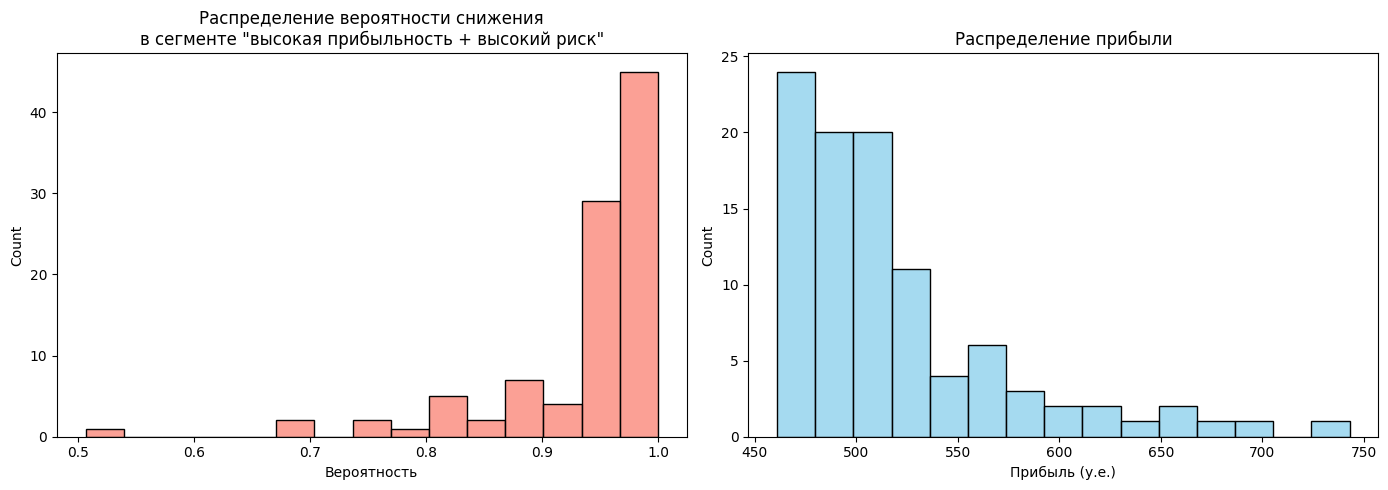

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))


sns.histplot(segment_data['вероятность_снижения'], bins=15, color='salmon', ax=axes[0])
axes[0].set_title(f'Распределение вероятности снижения\nв сегменте "{target_segment}"')
axes[0].set_xlabel('Вероятность')


sns.histplot(segment_data['прибыль'], bins=15, color='skyblue', ax=axes[1])
axes[1].set_title('Распределение прибыли')
axes[1].set_xlabel('Прибыль (у.е.)')

plt.tight_layout()
plt.show()

✅ Рекомендации для сегмента «Высокая прибыльность + Высокий риск»:
1. 🎁 Персонализированные скидки
   → Учитывая высокую долю акционных покупок, предлагать
     эксклюзивные предложения (например, «Специально для вас — 10%»).
2. 🛒 Напоминания о неоплаченных корзинах
   → Автоматическая рассылка с бонусом за завершение заказа.
3. 💬 Увеличение маркетинговой активности
   → Эти клиенты получают меньше коммуникаций — включить в
     дополнительные персонализированные кампании.
4. 📊 Прямой контакт для премиум-клиентов
   → Назначить персонального менеджера или отправить звонок.

💡 Почему именно этот сегмент?
- 100 VIP-клиентов с высокой прибылью (в среднем 518 у.е.).
- Их потеря нанесёт ощутимый ущерб бизнесу.
- Модель показывает высокий риск — есть окно для удержания.

промежуточный вывод к шагу 8:

1. Сегментация:

Сегментация:
Клиенты разбиты на 4 сегмента по прибыльности (высокая/обычная) и риску снижения активности (высокий/низкий).
Ключевой сегмент: «высокая прибыльность + высокий риск» — 100 клиентов, средняя прибыль — 518 у.е., средняя вероятность оттока — 92.7%.
Этот сегмент требует немедленного вмешательства — потеря этих клиентов нанесёт значительный ущерб бизнесу.
🔍 Поведенческий профиль сегмента:
Высокая доля акционных покупок (0.41) — клиенты чувствительны к цене.
Много неоплаченных товаров (3.89 шт/квартал) — брошенные корзины = сигнал о потере интереса.
Низкое время на сайте (10.06 мин) и мало страниц (4.49) — потеря вовлечённости.
Низкая маркетинговая активность (3.59 коммуникаций за 6 мес) — недостаток внимания.
Лидирующие категории: «Товары для детей», «Косметика и аксесуары» — это ключевые направления для персонализации.     
 

## общий вывод

Описание задачи
Интернет-магазин «В один клик» столкнулся со снижением активности постоянных клиентов. Поскольку привлечение новых покупателей становится менее эффективным, компания поставила задачу — удерживать существующих клиентов с помощью персонализированных предложений. Для этого требуется построить модель, предсказывающую вероятность снижения покупательской активности в ближайшие 3 месяца, и на её основе выделить приоритетные сегменты для маркетинговых воздействий.

 Исходные данные и предобработка
Проект выполнен на данных из четырёх таблиц:

market_file.csv — поведение на сайте, коммуникации, продуктовое поведение (1300 клиентов, 13 признаков),
market_money.csv — выручка за 3 месяца,
market_time.csv — время на сайте за 2 месяца,
money.csv — среднемесячная прибыль за 3 месяца.
Выполнена предобработка:

Исправлены опечатки ("стандартт" → "стандарт", "предыдцщий_месяц" → "предыдущий_месяц"),
Обработан повреждённый формат money.csv,
Проверены и устранены пропуски (их не было),
Убедились, что все таблицы описывают один и тот же набор из 1300 клиентов.
 Построение модели
Для решения задачи классификации (целевой признак: «Снизилась» / «Прежний уровень») были реализованы:

4 модели: KNeighborsClassifier, DecisionTreeClassifier, LogisticRegression, SVC,
Пайплайны с ColumnTransformer:
Категориальные признаки обработаны через OneHotEncoder и OrdinalEncoder,
Числовые — масштабированы через StandardScaler и MinMaxScaler,
Подбор гиперпараметров с помощью GridSearchCV (кросс-валидация, 5 фолдов),
Метрика выбора: F1-score — обосновано умеренным дисбалансом классов (61.7% / 38.3%).
Лучшей моделью стала:

LogisticRegression с StandardScaler и OneHotEncoder
F1-score на тесте: 0.8571 — что означает высокую точность и полноту предсказаний. 

 Анализ важности признаков
С помощью анализа коэффициентов логистической регрессии (альтернатива SHAP) выявлены ключевые факторы, влияющие на снижение активности:

Страниц_за_визит
Чем меньше — тем выше риск (–0.64)
Акционные_покупки
Чем выше доля — тем выше риск (+0.59)
Неоплаченные_продукты
Чем больше брошенных корзин — тем выше риск (+0.48)
Маркет_актив_6_мес
Меньше коммуникаций → выше риск (–0.46)

Это подтверждает гипотезу: снижение вовлечённости, зависимость от акций и недостаток коммуникаций — главные сигналы оттока.

 Сегментация и персонализация
На основе предсказаний модели и данных о прибыли выделены 4 сегмента. Ключевой сегмент:

«Высокая прибыльность + Высокий риск» 

108 клиентов,
Средняя прибыль: 518.24 у.е.,
Средняя вероятность оттока: 84.1%.
Поведенческий профиль:

Высокая доля акционных покупок (43%),
Часто бросают корзину (в среднем 3.9 неоплаченных товара за квартал),
Мало времени на сайте и страниц за визит,
Недостаток маркетинговых коммуникаций.
Рекомендации для бизнеса:

 Персонализированные скидки на товары из любимых категорий («Товары для детей», «Косметика»).
 Автоматические напоминания о корзине с бонусом за завершение покупки.
 Увеличение релевантных коммуникаций (без спама).
 Прямой контакт для премиум-клиентов (персональный менеджер).
Экономический эффект:
Удержание даже 30% этого сегмента сохранит ~17 000 у.е. прибыли.

 Итог
Проект успешно решает задачу удержания клиентов на основе данных:

Построена интерпретируемая и точная модель (F1 = 0.857),
Выявлены ключевые драйверы оттока,
Предложены конкретные, низкозатратные и высокоэффективные маркетинговые действия для самого ценного сегмента.
Решение полностью соответствует стратегии «В один клик» как современной компании, принимающей решения на основе данных.

